# 🚀 Ignition + CIFAR10

A basic demo of using Ignition to train a CIFAR-10 model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Allow Python to find ignition.
import sys
sys.path.insert(0, "../")

In [3]:
import importlib
import ignition; importlib.reload(ignition)
from ignition import *

In [4]:
ignition.__version__

'0.0.1'

In [5]:
ignition.print_cuda_info()

cuDNN version: 7003
Available CUDA devices:
0: GeForce GTX 1080 Ti, capability 6.1 (current)


## The model

This is only a very basic convnet. Not particulary state-of-the-art. ;-)

In [6]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Conv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = Conv(3, 16, 3)
        self.conv2 = Conv(16, 32, 3)
        self.conv3 = Conv(32, 64, 3)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.avg_pool2d(self.conv2(x), 2)
        x = F.avg_pool2d(self.conv3(x), 2)
        x = x.view(-1, flattened_size(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # logits

In [7]:
def create_model():
    net = Net()
    net.cuda()
    return net

In [8]:
net = create_model()

Show a summary of the model's parameters.

In [9]:
print_parameter_sizes(net)

Parameter                      | Size                     | Count        | Train?
conv1.conv.weight              | 16 × 3 × 3 × 3           |          432 | Yes   
conv1.conv.bias                | 16                       |           16 | Yes   
conv1.bn.weight                | 16                       |           16 | Yes   
conv1.bn.bias                  | 16                       |           16 | Yes   
conv2.conv.weight              | 32 × 16 × 3 × 3          |         4608 | Yes   
conv2.conv.bias                | 32                       |           32 | Yes   
conv2.bn.weight                | 32                       |           32 | Yes   
conv2.bn.bias                  | 32                       |           32 | Yes   
conv3.conv.weight              | 64 × 32 × 3 × 3          |        18432 | Yes   
conv3.conv.bias                | 64                       |           64 | Yes   
conv3.bn.weight                | 64                       |           64 | Yes   
conv3.bn.bias   

Show the shapes of the tensors at every layer for a 32×32 input image.

In [10]:
print_activation_sizes(net, (1, 3, 32, 32))

Module                         | Input Size               | Output Size             
conv1                          | 1 × 3 × 32 × 32          | 1 × 16 × 32 × 32        
conv2                          | 1 × 16 × 16 × 16         | 1 × 32 × 16 × 16        
conv3                          | 1 × 32 × 8 × 8           | 1 × 64 × 8 × 8          
fc1                            | 1 × 1024                 | 1 × 128                 
fc2                            | 1 × 128                  | 1 × 10                  


In [11]:
print_activation_sizes(net.conv1, (1, 3, 32, 32))

Module                         | Input Size               | Output Size             
conv                           | 1 × 3 × 32 × 32          | 1 × 16 × 32 × 32        
bn                             | 1 × 16 × 32 × 32         | 1 × 16 × 32 × 32        


Show a picture of the model:

In [ ]:
plot_graph(net, (1, 3, 32, 32))

PyTorch will now have allocated tensors for the weights and their gradients.

In [12]:
dump_tensors()

Parameter → FloatTensor: GPU pinned grad 16 × 3 × 3 × 3
Parameter → FloatTensor: GPU pinned grad 16
Parameter → FloatTensor: GPU pinned grad 16
Parameter → FloatTensor: GPU pinned grad 16
Parameter → FloatTensor: GPU pinned grad 32 × 16 × 3 × 3
Parameter → FloatTensor: GPU pinned grad 32
Parameter → FloatTensor: GPU pinned grad 32
Parameter → FloatTensor: GPU pinned grad 32
Parameter → FloatTensor: GPU pinned grad 64 × 32 × 3 × 3
Parameter → FloatTensor: GPU pinned grad 64
Parameter → FloatTensor: GPU pinned grad 64
Parameter → FloatTensor: GPU pinned grad 64
Parameter → FloatTensor: GPU pinned grad 128 × 1024
Parameter → FloatTensor: GPU pinned grad 128
Parameter → FloatTensor: GPU pinned grad 10 × 128
Parameter → FloatTensor: GPU pinned grad 10
FloatTensor: GPU pinned 16 × 3 × 3 × 3
FloatTensor: GPU pinned 16
FloatTensor: GPU pinned 16
FloatTensor: GPU pinned 16
FloatTensor: GPU pinned 16
FloatTensor: GPU pinned 16
FloatTensor: GPU pinned 32 × 16 × 3 × 3
FloatTensor: GPU pinned 32
Fl

In [ ]:
!nvidia-smi

## The dataset

In [13]:
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
num_classes = len(classes)

CIFAR-10 data is often preprocessed using ZCA whitening but we just normalize it using the mean and stddev over the training set.

In [14]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

In [15]:
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, 
                                        transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                                          num_workers=4, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, 
                                         num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
print("Train examples:", data_loader_sample_count(trainloader))
print(" Test examples:", data_loader_sample_count(testloader))

Train examples: 50000
 Test examples: 10000


Look at some of the data:

In [17]:
def untransform(img):
    mean = torch.Tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.Tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    return torch.clamp(img*std + mean, 0., 1.)

In [18]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

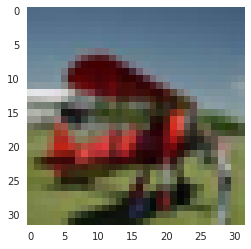

In [19]:
imshow(images[0], untransform)

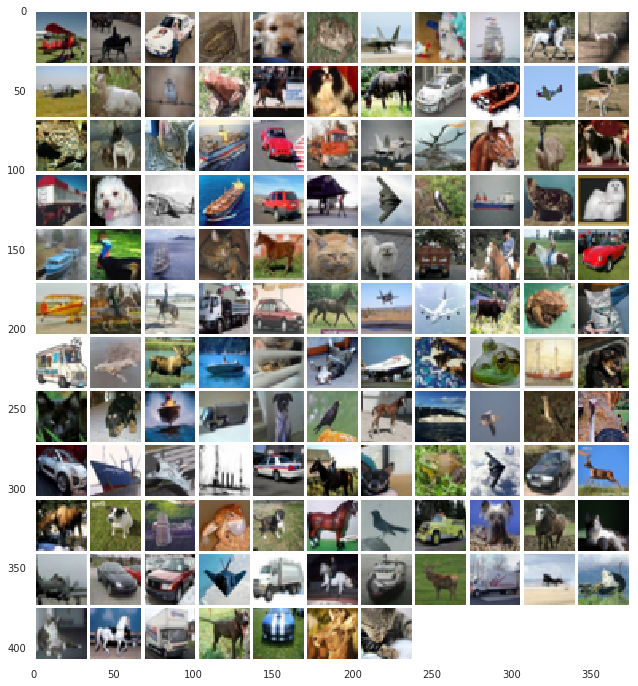

In [20]:
grid = torchvision.utils.make_grid(images, pad_value=255, nrow=int(np.sqrt(batch_size)))
imshow(grid, untransform, figsize=(12, 12))

## Training

Create output folder where we'll store the trained model and intermediate checkpoints.

In [21]:
output_dir = "checkpoints/cifar10/"
mkdir_if_needed(output_dir)

Define the loss function:

In [22]:
crossentropy_loss = nn.CrossEntropyLoss()

Define the evaluation function. Since this is a classifier we use the built-in `evaluate_on_batch()`.

In [23]:
def eval_fn(model_to_eval, x, y):
    return evaluate_on_batch(model_to_eval, x, y, crossentropy_loss, ["loss", "acc"])

Evaluating an untrained model on the test set should give initial loss of `-ln(1/num_classes) = 2.30258`. Initial accuracy should be `1/num_classes = 0.1`. These values are approximate because of the random initialization of the layers.

In [24]:
evaluate(net, eval_fn, testloader)

79 steps - 0s - loss: 2.30358, acc: 0.10000                              


{'acc': 0.1, 'loss': 2.303575965422618}

Define the training function. This uses the built-in `fit_on_batch()`.

In [25]:
def train_fn(model, x, y):
    return fit_on_batch(model, x, y, crossentropy_loss, optimizer)

## Find the best learning rate

Create the optimizer:

In [26]:
optimizer = optim.SGD(trainable_parameters(net), lr=0.01, momentum=0.9, weight_decay=1e-4)

Create the trainer object that performs the actual training loop. Note that the trainer does not know anything about how the actual training happens.

In [27]:
trainer = Trainer(net, train_fn, trainloader, eval_fn, testloader)

Use the `LRFinder` callback to sweep the learning rate between 1e-5 and 1e2, to see which works best.

In [28]:
trainer.callbacks = [ LRFinder(optimizer, 1e-5, 10, 300) ]

Run the training loop for a single epoch (or less, if the loss explodes):

In [29]:
trainer.fit(epochs=1)

Train epochs 1-1 on 50000 examples, validate on 10000 examples
epoch   | steps | time  | tr loss  | tr acc  | val loss | val acc                                    
1/1     |   300 | 1s    | 991.1403 | 0.20531 | 18752592 | 0.10000


Plot the learning rate vs the loss to find our optimal learning rate:

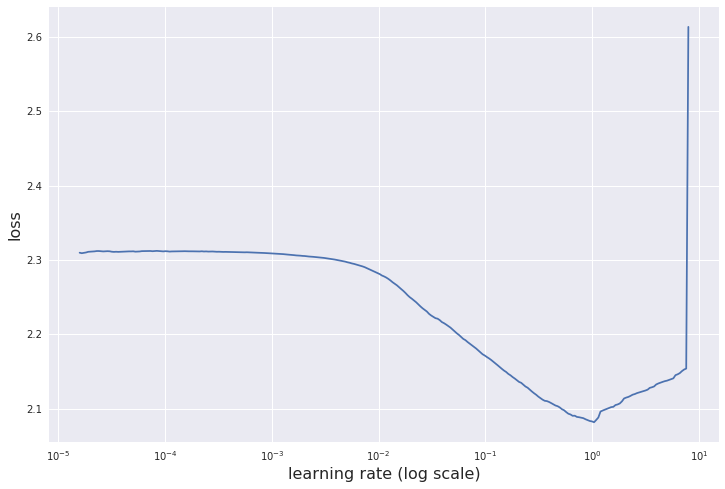

In [30]:
trainer.callbacks[0].plot()

It looks like 0.1 is a good starting point.

### Train for real

Finding the learning rate changed our model and optimizer state, so restore the empty starting state. We could have saved the model parameters and optimizer state, but easiest is to make new instances of everything.

In [31]:
net = create_model()

In [32]:
lr = 0.1
optimizer = optim.SGD(trainable_parameters(net), lr=lr, momentum=0.9, weight_decay=1e-4)

In [33]:
trainer = Trainer(net, train_fn, trainloader, eval_fn, testloader)

Define callbacks:

In [34]:
trainer.callbacks = [
    # Save a model checkpoint after every 10 epochs. This also includes training history.
    SaveModel(output_dir + "mymodel_ep{epoch:d}_loss{val_loss:.4f}_acc{val_acc:.4f}.pt",
              include_history=True, save_every=10, always_save_better=False, verbose=True),
    
    # Automatically schedule the learning rate.
    #LRSchedule(torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1))
    
    # Use stochastic gradient descent with warm restarts.
    CosineAnneal(optimizer, lr_min=1e-4, lr_max=1e-1, cycle_len=1, cycle_mult=2)
]

Start training!

In [35]:
trainer.fit(epochs=15)

Train epochs 1-15 on 50000 examples, validate on 10000 examples
epoch   | steps | time  | tr loss  | tr acc  | val loss | val acc                                    
 1/15   |   391 | 1s    |  1.42741 | 0.47656 |  1.12355 | 0.59220
 2/15   |   391 | 1s    |  1.11738 | 0.60262 |  0.94079 | 0.66540                                    
 3/15   |   391 | 1s    |  0.82025 | 0.70988 |  0.79070 | 0.72260                                    
 4/15   |   391 | 1s    |  0.91070 | 0.68110 |  0.97537 | 0.66410                                    
 5/15   |   391 | 1s    |  0.75361 | 0.73448 |  0.79252 | 0.72670                                    
 6/15   |   391 | 1s    |  0.62238 | 0.78130 |  0.65869 | 0.77200                                    
 7/15   |   391 | 1s    |  0.53387 | 0.81384 |  0.63665 | 0.77780                                    
 8/15   |   391 | 1s    |  0.71924 | 0.74886 |  0.84037 | 0.70980                                    
 9/15   |   391 | 1s    |  0.65962 | 0.76646 |  0.8159

How have we been doing so far?

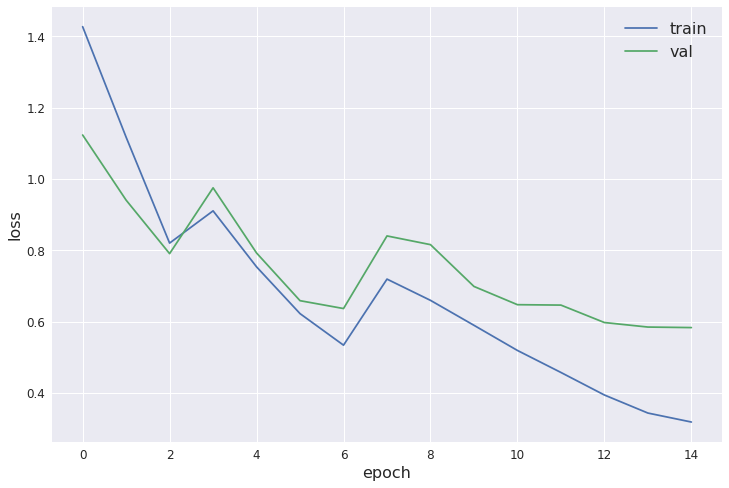

In [36]:
trainer.history.plot_loss()

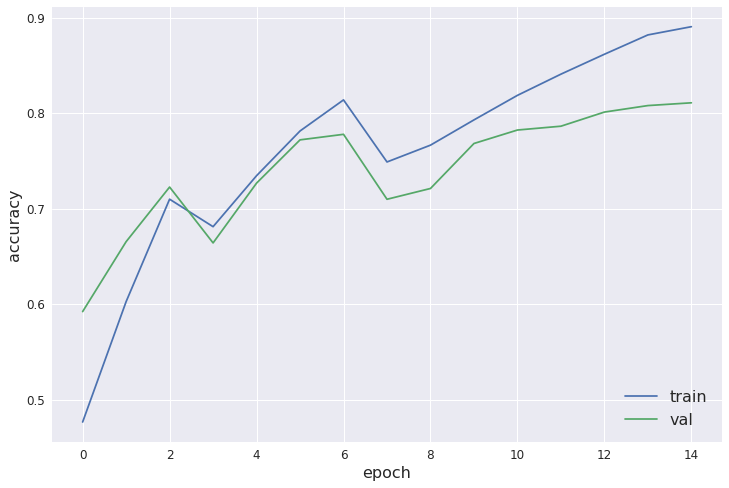

In [37]:
trainer.history.plot_accuracy()

How the learning rate has changed over time:

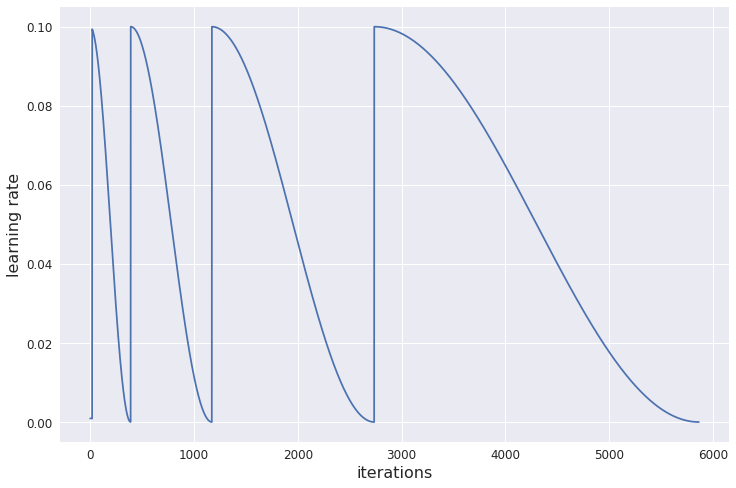

In [38]:
trainer.history.plot("lr", xlabel="iterations", ylabel="learning rate")

Get rid of the cosine annealing callback:

In [39]:
del trainer.callbacks[-1]

From now on, still save a checkpoint every 10 epochs but also whenever the validation accuracy improves.

In [41]:
trainer.callbacks[0].always_save_better=True

Manual learning rate annealing:

In [42]:
lr *= 0.1; set_lr(optimizer, lr); lr

0.010000000000000002

In [43]:
trainer.fit(epochs=10)

Train epochs 16-25 on 50000 examples, validate on 10000 examples
epoch   | steps | time  | tr loss  | tr acc  | val loss | val acc                                    
16/25   |   391 | 1s    |  0.33172 | 0.88506 |  0.59077 | 0.80760
17/25   |   391 | 1s    |  0.32203 | 0.88866 |  0.60154 | 0.80490                                    
18/25   |   391 | 1s    |  0.31473 | 0.89078 |  0.59792 | 0.80680                                    
19/25   |   391 | 1s    |  0.30179 | 0.89542 |  0.60145 | 0.80650                                    
20/25   |   391 | 1s    |  0.29620 | 0.89788 |  0.61810 | 0.80710                                    
💾 Saving model to checkpoints/cifar10/mymodel_ep20_loss0.6181_acc0.8071.pt
21/25   |   391 | 1s    |  0.28666 | 0.90208 |  0.61721 | 0.80930                                    
22/25   |   391 | 1s    |  0.28256 | 0.90168 |  0.62218 | 0.80280                                    
23/25   |   391 | 1s    |  0.27378 | 0.90568 |  0.61751 | 0.80590               

In [44]:
lr *= 0.1; set_lr(optimizer, lr); lr

0.0010000000000000002

In [45]:
trainer.fit(epochs=10)

Train epochs 26-35 on 50000 examples, validate on 10000 examples
epoch   | steps | time  | tr loss  | tr acc  | val loss | val acc                                    
26/35   |   391 | 1s    |  0.22683 | 0.92524 |  0.61713 | 0.81170
😊 val_acc improved from 0.8108 to 0.8117
💾 Saving model to checkpoints/cifar10/mymodel_ep26_loss0.6171_acc0.8117.pt
27/35   |   391 | 1s    |  0.22338 | 0.92728 |  0.61606 | 0.81240                                    
😊 val_acc improved from 0.8117 to 0.8124
💾 Saving model to checkpoints/cifar10/mymodel_ep27_loss0.6161_acc0.8124.pt
28/35   |   391 | 1s    |  0.22051 | 0.92928 |  0.61692 | 0.81130                                    
29/35   |   391 | 1s    |  0.21833 | 0.92980 |  0.61917 | 0.81150                                    
30/35   |   391 | 1s    |  0.21591 | 0.93120 |  0.62050 | 0.81110                                    
31/35   |   391 | 1s    |  0.21700 | 0.93010 |  0.62412 | 0.81140                                    
32/35   |   391 | 1s    |

Plot the loss and accuracy curves.

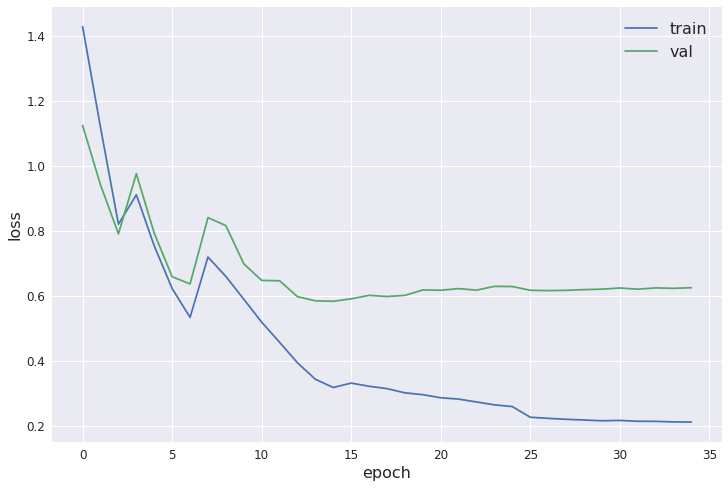

In [46]:
trainer.history.plot_loss()

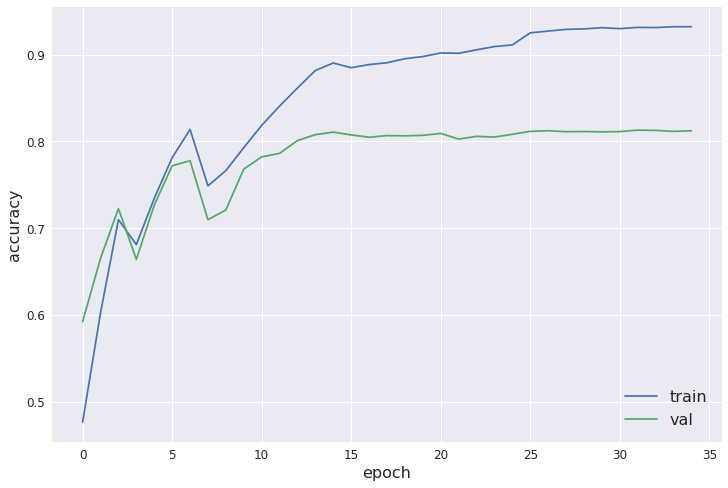

In [47]:
trainer.history.plot_accuracy()

In [48]:
trainer.history.best_epoch()

{'epoch': 31, 'val_acc': 0.8131}

(Note that we count epochs from 0 but the progress report starts counting from 1, so this best epoch was actually saved as "32" rather than 31.)

## Evaluating the model

Load the best checkpoint:

In [49]:
checkpoint = torch.load(output_dir + "mymodel_ep32_loss0.6205_acc0.8131.pt")
net.load_state_dict(checkpoint["model"])

In [50]:
evaluate(net, eval_fn, testloader)

79 steps - 0s - loss: 0.62048, acc: 0.81310                              


{'acc': 0.8131, 'loss': 0.6204840714418436}

Run prediction over the test set:

In [51]:
y_pred = predict(net, predict_on_batch, testloader, verbose=True)

79/79 ██████████████████████████████ ETA 0s


In [52]:
y_pred_idx = from_onehot(y_pred)
len(y_pred), len(y_pred_idx)

(10000, 10000)

In [53]:
y_val = testset.test_labels

Confusion matrix

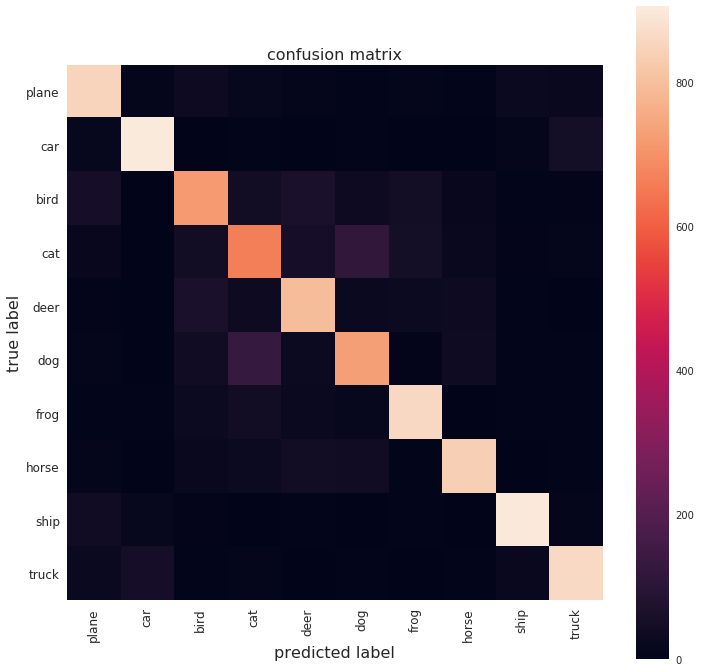

In [54]:
confusion_matrix(y_val, y_pred_idx, classes)

How often does each class get predicted?

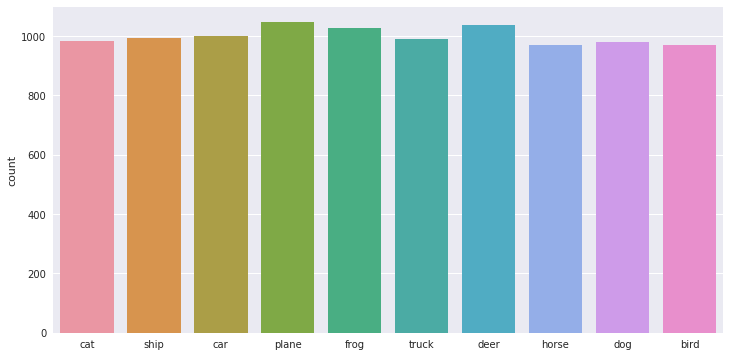

In [55]:
plot_target_counts(y_pred_idx, classes)

Precision / recall

In [56]:
precision_recall(y_val, y_pred_idx, classes)

             precision    recall  f1-score   support

      plane       0.81      0.85      0.83      1000
        car       0.90      0.91      0.90      1000
       bird       0.74      0.72      0.73      1000
        cat       0.67      0.66      0.67      1000
       deer       0.77      0.80      0.78      1000
        dog       0.74      0.73      0.74      1000
       frog       0.84      0.86      0.85      1000
      horse       0.87      0.84      0.85      1000
       ship       0.91      0.90      0.90      1000
      truck       0.87      0.86      0.87      1000

avg / total       0.81      0.81      0.81     10000



The network outputs logits, so compute the softmax to convert the predictions to percentages:

In [57]:
y_pred_softmax = F.softmax(make_var(y_pred), dim=1)
y_pred_softmax.shape

torch.Size([10000, 10])

In [58]:
y_pred_ = y_pred_softmax.data.cpu().numpy()
y_true_ = np.array(y_val)

## Correct vs. incorrect predictions

Look at some random correct predictions for cat:

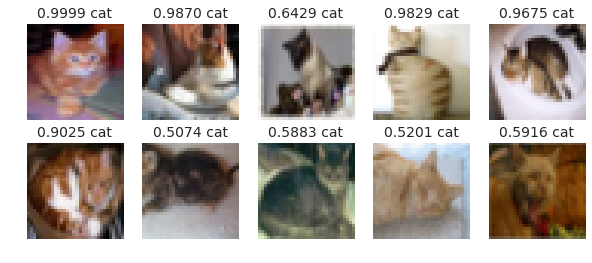

In [59]:
plot_random_correct(3, y_pred_, y_true_, testset.test_data, classes, nrows=2)

And some random incorrect predictions for cat. (The probability is for class cat, the label is the true label.)

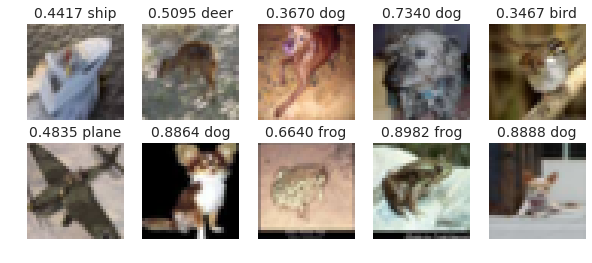

In [60]:
plot_random_incorrect(3, y_pred_, y_true_, testset.test_data, classes, nrows=2)

Correct predictions for cats with the highest confidence:

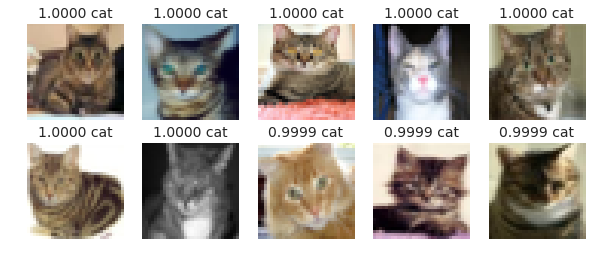

In [61]:
plot_most_confident_correct(3, y_pred_, y_true_, testset.test_data, classes, nrows=2)

And with the lowest confidence:

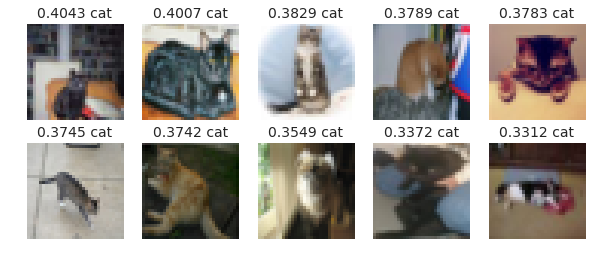

In [62]:
plot_least_confident_correct(3, y_pred_, y_true_, testset, classes, 
                             nrows=2, untransform=untransform)

Show the images that were most confidently classified as "cat" but aren't. This is the error in precision. (The labels shown are the true labels.)

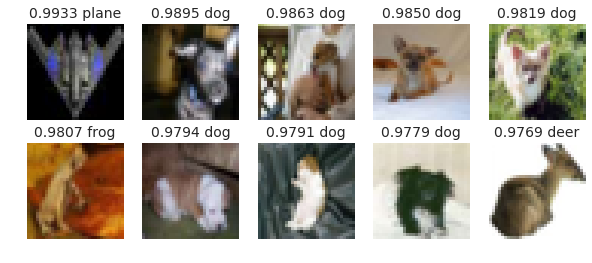

In [63]:
plot_most_confident_incorrect_by_precision(3, y_pred_, y_true_, testset, classes, 
                                           nrows=2, untransform=untransform)

Show the images that were classified as "cat" but aren't, but where the confidence is quite low.

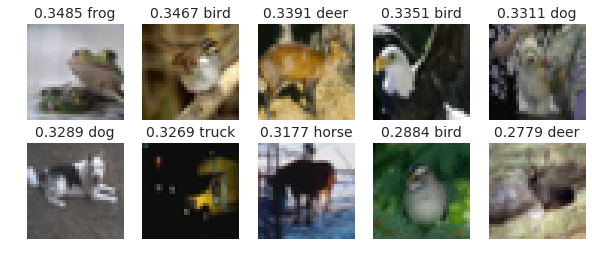

In [64]:
plot_least_confident_incorrect_by_precision(3, y_pred_, y_true_, testset, classes, 
                                            nrows=2, untransform=untransform)

Show the images that are cats but are confidently classified to be something else, i.e. these are examples that the model "missed". This is the error in recall. (The percentages shown are the predicted probabilities for cat, because that's the class we're interested in. The labels are what the model predicted; the true label is "cat".)

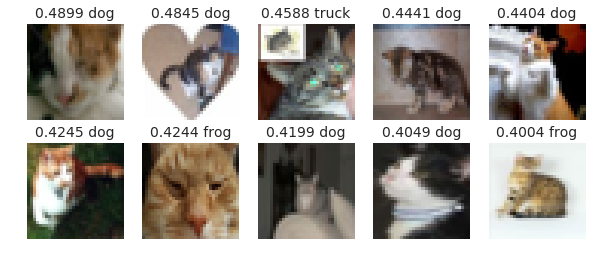

In [65]:
plot_most_confident_incorrect_by_recall(3, y_pred_, y_true_, testset, classes, 
                                        nrows=2, untransform=untransform)

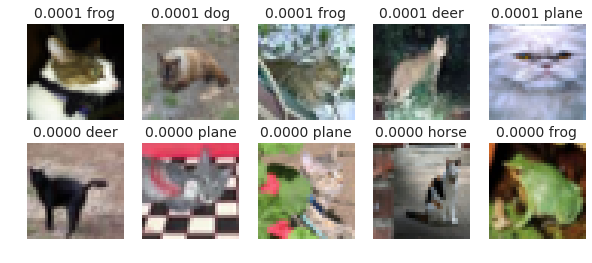

In [29]:
plot_least_confident_incorrect_by_recall(3, y_pred_, y_true_, testset, classes, 
                                         nrows=2, untransform=untransform)

Note: that last example really does look like a frog, not a cat. It appears that the label is wrong.

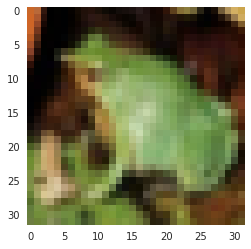

cat


In [41]:
imshow(testset.test_data[2405])
print(classes[testset.test_labels[2405]])

Show the most uncertain predictions across the entire dataset. The labels are the predicted labels.

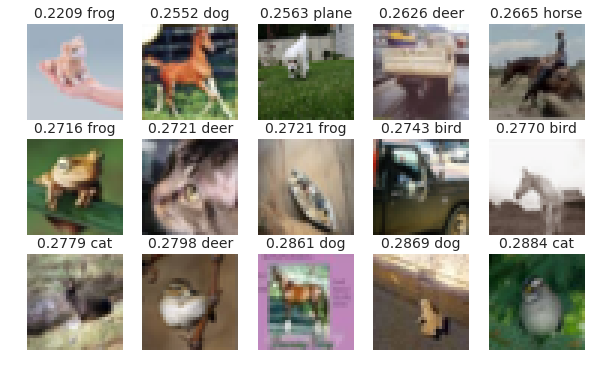

In [66]:
plot_most_uncertain(y_pred_, y_true_, testset, classes, 15, 3, untransform)

## Making new predictions

Make a prediction on a picture that is not in the dataset:

In [67]:
resize_transform = transforms.Compose([
    torchvision.transforms.Resize((32, 32)),  # resize to 32x32
    transform_test                            # + previous transforms
])

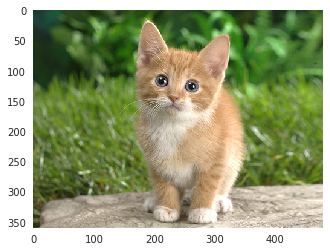

In [68]:
img = PIL.Image.open("cat.jpg")
imshow(img)

In [69]:
img_tensor = resize_transform(img).unsqueeze(0)
y_pred = predict_on_batch(net, img_tensor)
y_pred.size()

torch.Size([1, 10])

In [70]:
y_pred


-7.2639 -7.3618  2.0022  6.0577  8.4191  5.7858  0.7814  2.2087 -7.2750 -3.9744
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]

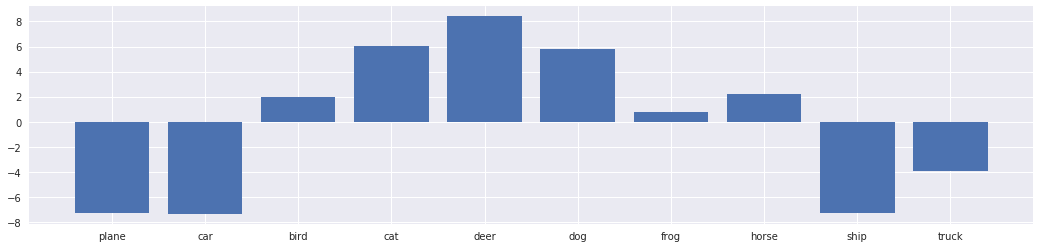

In [71]:
plot_predictions(y_pred.squeeze(), classes)

The predictions are before the softmax, since we use `CrossEntropyLoss`. Compute the softmax manually to get percentages:

In [72]:
y_pred_softmax = F.softmax(make_var(y_pred.squeeze()), dim=0)

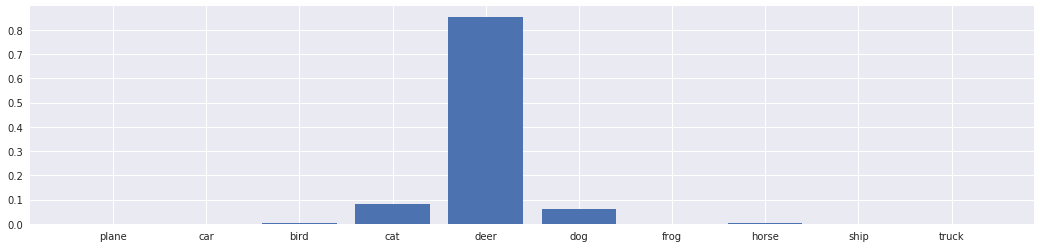

In [73]:
plot_predictions(y_pred_softmax, classes)

In [74]:
print_top5(y_pred_softmax, classes)

0.85452 deer
0.08057 cat
0.06139 dog
0.00172 horse
0.00140 bird


Looks like we need a better model! :-)

## Visualizations

The weights of the first conv layer:

In [75]:
W = net.conv1.conv.weight
W.size()

torch.Size([16, 3, 3, 3])

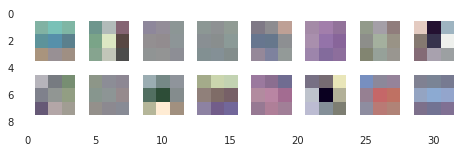

In [76]:
grid = torchvision.utils.make_grid(W.data.cpu(), normalize=True, padding=1, pad_value=1, nrow=8)
imshow(grid, figsize=(8, 8))

Get the output of an intermediate layer (here the second convolution layer):

In [77]:
output = forward(net, [net.conv2], img_tensor)[0]
output.size()

torch.Size([1, 32, 16, 16])

In [127]:
# Use this to grab the output *before* the ReLU:
output = net.conv1.conv(make_var(img_tensor))

Histogram of the activations of this layer:

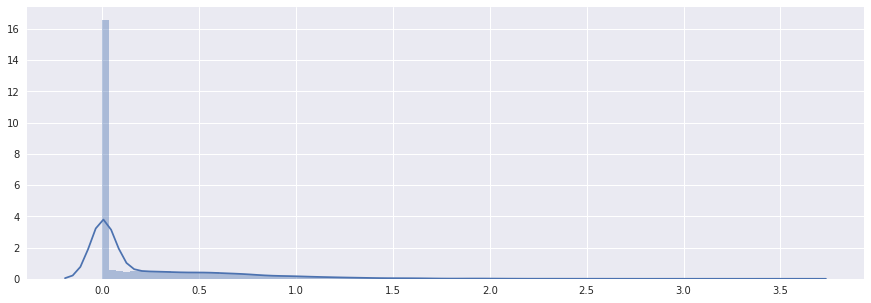

In [78]:
feat = output.data.cpu().numpy().ravel()
fig = plt.figure(figsize=(15, 5))
sns.distplot(feat, bins=100)
plt.show()

Activations of this layer, where each feature map is a grayscale image.

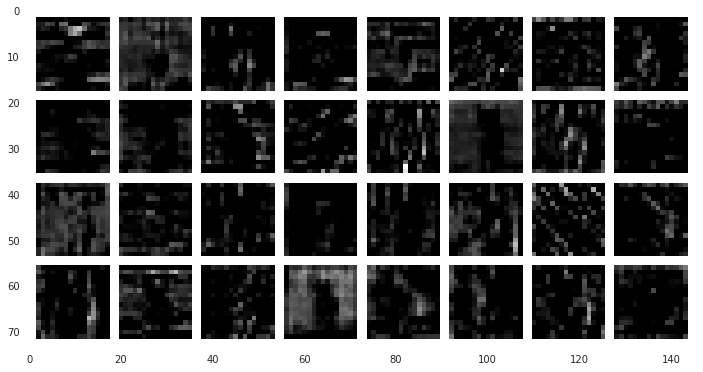

In [79]:
data = output.data.cpu().permute(1, 0, 2, 3)
grid = torchvision.utils.make_grid(data, normalize=True, padding=2, pad_value=1, nrow=8)
imshow(grid, figsize=(12, 12))

## Find similar images

If two images produce activations that are similar (i.e. have a small Euclidian distance), then we can consider those images to have similar contents. We can do this at different layers in the network.

In [80]:
# Computes the (intermediate) activations for all test images.
def compute_activations(layer):
    activations = []
    handle = layer.register_forward_hook(lambda module, inp, out: activations.append(out))
    _ = predict(net, predict_on_batch, testloader, verbose=True)
    handle.remove()

    # Combine into one big tensor.
    activations = torch.cat(activations, dim=0)
    return activations

In [81]:
activations = compute_activations(net.fc1).view(-1, 128)
activations.size()

79/79 ██████████████████████████████ ETA 0s


torch.Size([10000, 128])

In [82]:
def plot_similar_images(activations, compare_with, N=20):
    # Compute the Euclidian distance between the chosen image and
    # every other image in the test set.
    distances = (activations[compare_with] - activations).norm(dim=1)

    # Sort by smallest distance. The "compare_with" image always shows up as
    # the first image because its distance with itself is 0.
    _, indices = torch.sort(distances, dim=0)
    closest_images = indices[:N].data.cpu().numpy()

    # Gather the images.
    image_data = []
    for i, ix in enumerate(closest_images):
        image_data.append(testset[ix][0])
    image_data = torch.stack(image_data, dim=0)

    # Plot them.
    grid = torchvision.utils.make_grid(image_data, normalize=True, padding=2, pad_value=1, nrow=5)
    imshow(grid, figsize=(8, 8))

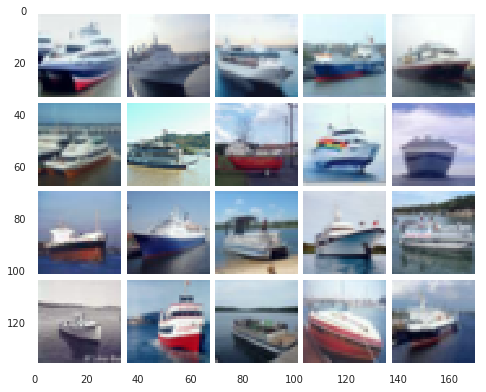

In [83]:
plot_similar_images(activations, 1)

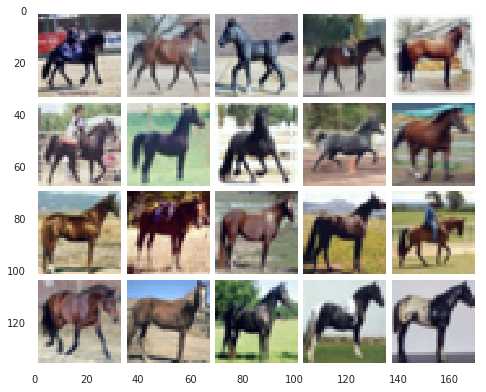

In [84]:
plot_similar_images(activations, 5000)

## What do filters learn?

We can find out which images activate certain convolution filters the most.

In [85]:
def predict_norm(layer, channel):
    def pred(model, x):
        batch_pred = forward(model, [layer], x)[0]
        norm = batch_pred.data[:, channel, :, :].contiguous()
        norm = norm.view(-1, norm.size(1)*norm.size(2)).norm(p=1, dim=1)
        return norm
    return pred

def plot_images_with_largest_activations(activations, labels, dataset, classes, k, nrows, untransform=None):
    idxs = np.argsort(activations.numpy())[-k:][::-1]

    titles = []
    for i, idx in enumerate(idxs):
        titles.append(classes[labels[idx]])

    plot_images_from_indices_with_titles(idxs, dataset, titles, nrows, untransform)

In [86]:
y_true_ = np.array(testset.test_labels)

First conv layer. We'd expect this to capture simple patterns:

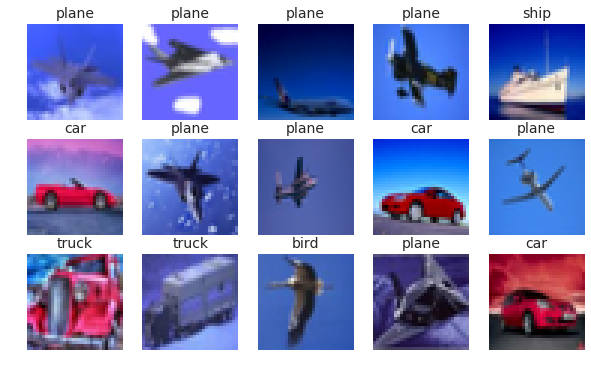

In [55]:
activations = predict(net, predict_norm(net.conv1, 5), testloader, verbose=False)
plot_images_with_largest_activations(activations, y_true_, testset, classes, 15, 3, untransform)

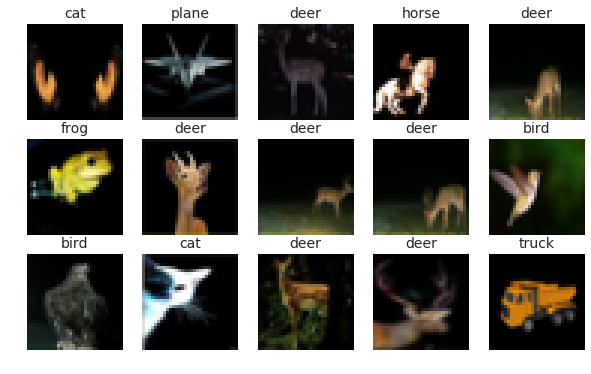

In [56]:
activations = predict(net, predict_norm(net.conv1, 14), testloader, verbose=False)
plot_images_with_largest_activations(activations, y_true_, testset, classes, 15, 3, untransform)

Second conv layer:

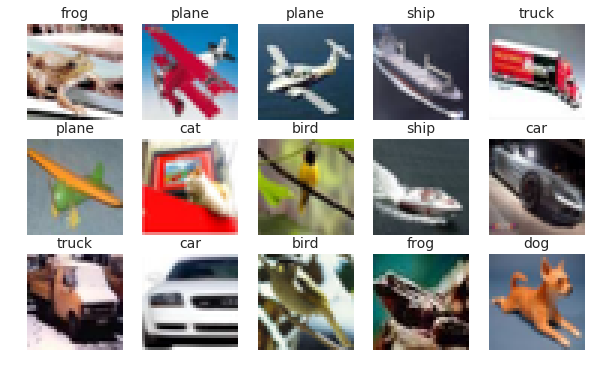

In [57]:
activations = predict(net, predict_norm(net.conv2, 4), testloader, verbose=False)
plot_images_with_largest_activations(activations, y_true_, testset, classes, 15, 3, untransform)

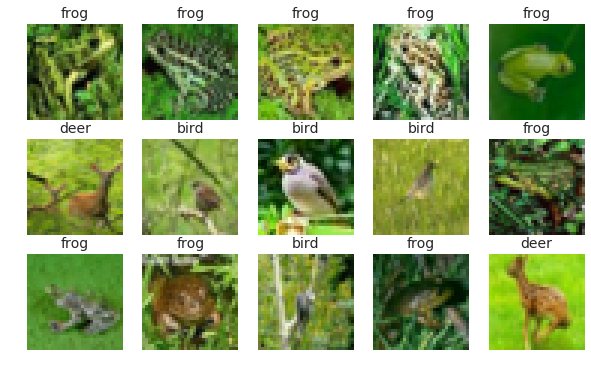

In [58]:
activations = predict(net, predict_norm(net.conv2, 19), testloader, verbose=False)
plot_images_with_largest_activations(activations, y_true_, testset, classes, 15, 3, untransform)

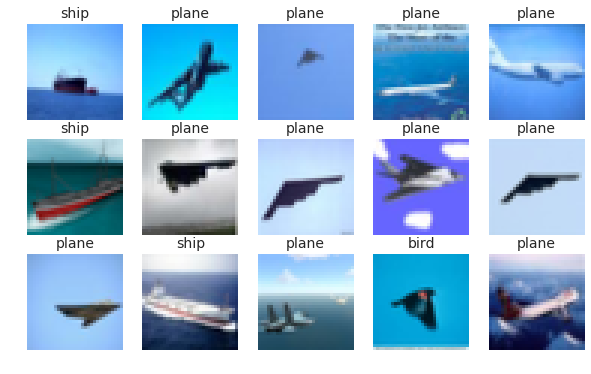

In [59]:
activations = predict(net, predict_norm(net.conv2, 23), testloader, verbose=False)
plot_images_with_largest_activations(activations, y_true_, testset, classes, 15, 3, untransform)

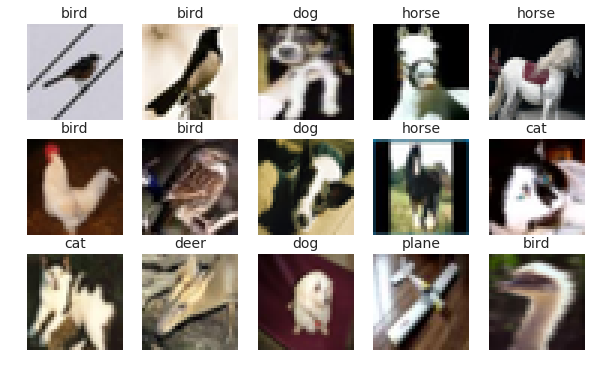

In [60]:
activations = predict(net, predict_norm(net.conv2, 27), testloader, verbose=False)
plot_images_with_largest_activations(activations, y_true_, testset, classes, 15, 3, untransform)

The third conv layer. This should start to capture higher-level concepts:

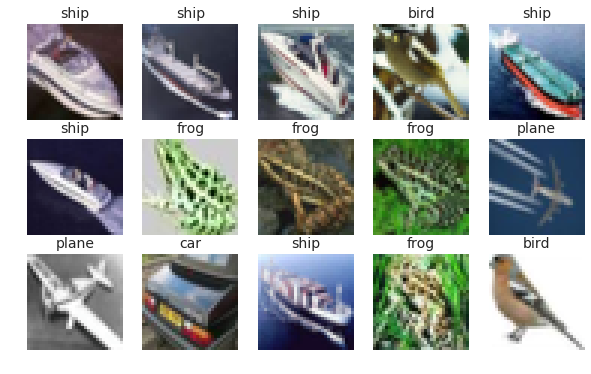

In [61]:
activations = predict(net, predict_norm(net.conv3, 3), testloader, verbose=False)
plot_images_with_largest_activations(activations, y_true_, testset, classes, 15, 3, untransform)

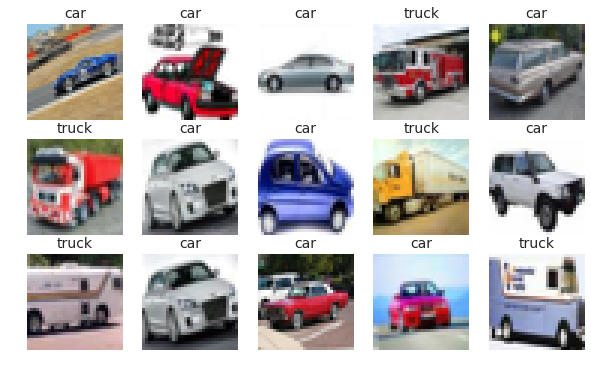

In [62]:
activations = predict(net, predict_norm(net.conv3, 8), testloader, verbose=False)
plot_images_with_largest_activations(activations, y_true_, testset, classes, 15, 3, untransform)

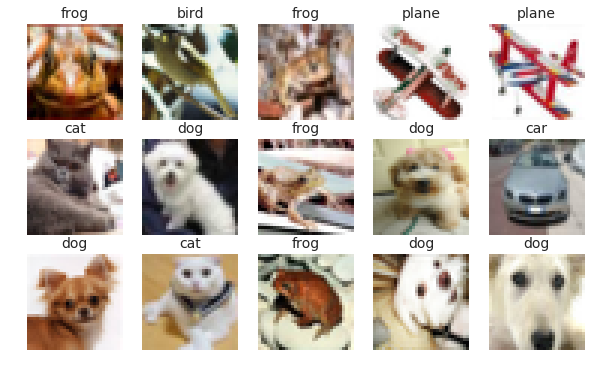

In [63]:
activations = predict(net, predict_norm(net.conv3, 14), testloader, verbose=False)
plot_images_with_largest_activations(activations, y_true_, testset, classes, 15, 3, untransform)

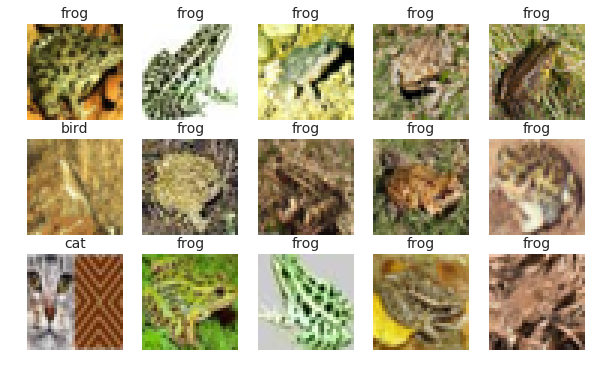

In [64]:
activations = predict(net, predict_norm(net.conv3, 21), testloader, verbose=False)
plot_images_with_largest_activations(activations, y_true_, testset, classes, 15, 3, untransform)

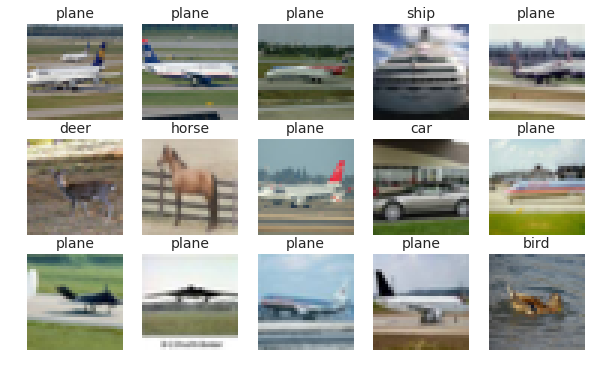

In [65]:
activations = predict(net, predict_norm(net.conv3, 60), testloader, verbose=False)
plot_images_with_largest_activations(activations, y_true_, testset, classes, 15, 3, untransform)